# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train[target_name].mean()

0.19044

In [9]:
train[target_name][train.DepTime > 2400].mean()

1.0

In [10]:
train[target_name][train.DepTime > 2400].shape

(17,)

In [11]:
train.shape

(100000, 9)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [14]:
test.shape

(100000, 8)

## Split Data

In [15]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

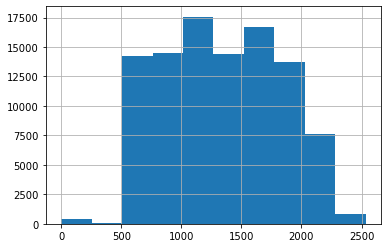

In [17]:
train.DepTime.hist()

In [18]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

In [19]:
time_groups = train.groupby((train.DepTime-1) // 100) 

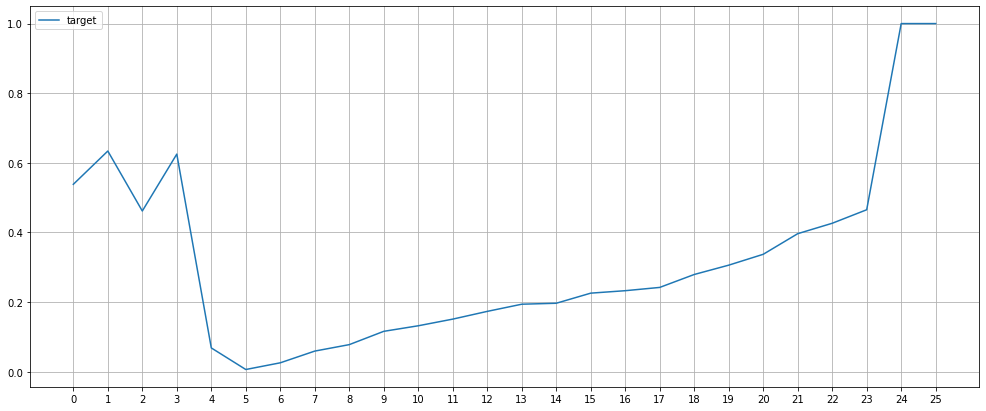

In [20]:
mean_by_t = time_groups[target_name].mean()
count_by_t = time_groups[target_name].count()

plt.figure(figsize=(17, 7))

plt.plot(mean_by_t.index, mean_by_t, label='target')
plt.xticks(range(0, 26))
plt.grid()
plt.legend()

## timestamp decoding

In [21]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## timestamp encoding

In [22]:
X = get_ts(X)

In [23]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,d_month,d_week,month
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,19,34,21,7,8
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,15,48,20,3,4
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,14,22,2,5,9
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,10,15,25,6,11
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,18,28,7,6,10


In [24]:
'2021-' + X.month.astype(str) + '-' + X.d_month.astype(str).str.zfill(2) + '-' + X.hour.astype(str).str.zfill(2) + '-' + X.minute.astype(str).str.zfill(2) + '-00'

0         2021-8-21-19-34-00
1         2021-4-20-15-48-00
2         2021-9-02-14-22-00
3        2021-11-25-10-15-00
4        2021-10-07-18-28-00
                ...         
99995     2021-5-04-16-18-00
99996     2021-1-18-08-04-00
99997     2021-1-24-19-01-00
99998     2021-4-27-15-15-00
99999    2021-11-17-18-00-00
Length: 100000, dtype: object

In [25]:
X_ = X[X.DepTime < 2400]
train['dep_dt'] = pd.to_datetime('2021-' + \
                             X_.month.astype(str).str.zfill(2) + '-' +
                             X_.d_month.astype(str).str.zfill(2) + '-' +
                             X_.hour.astype(str).str.zfill(2) + '-' +
                             X_.minute.astype(str).str.zfill(2) + '-00',
                             format='%Y-%m-%d-%H-%M-%S')

<AxesSubplot:>

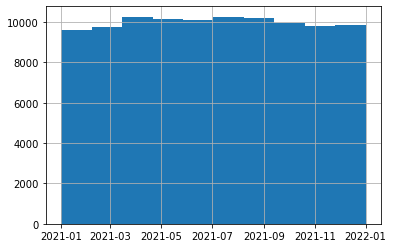

In [26]:
train.dep_dt.hist()

<AxesSubplot:xlabel='dep_dt'>

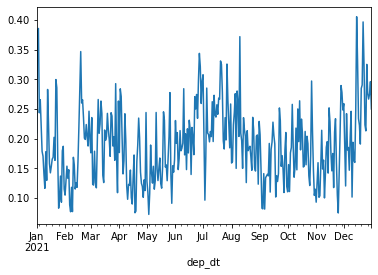

In [27]:
train.groupby(train.dep_dt.dt.to_period('d'))[target_name].mean().plot()

<AxesSubplot:xlabel='dep_dt'>

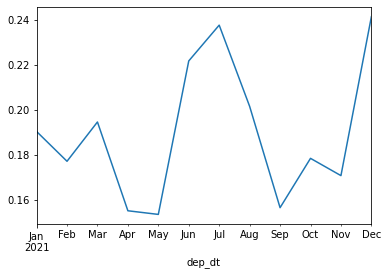

In [28]:
train.groupby(train.dep_dt.dt.to_period('M'))[target_name].mean().plot()

In [29]:
def ts_features(df):
    X_ = df[df.DepTime < 2400]
    dep_dt = pd.to_datetime('2021-' +
                                  X_.month.astype(str).str.zfill(2) + '-' +
                                  X_.d_month.astype(str).str.zfill(2) + '-' +
                                  X_.hour.astype(str).str.zfill(2) + '-' +
                                  X_.minute.astype(str).str.zfill(2) + '-00',
                                  format='%Y-%m-%d-%H-%M-%S')
    dep_td = dep_dt - pd.to_datetime('2021-01-01')
    df['days_since_ny'] = dep_td.dt.days
    df['secs_since_ny'] = dep_td.dt.seconds
    
    return df

## Category encoding

In [30]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [31]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [32]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [33]:
%%time
enc.fit(X_train[cat_cols])
print('Done')

Done
CPU times: user 146 ms, sys: 17 ms, total: 163 ms
Wall time: 185 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Sin/cos ts processing

In [34]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12),
             'days_since_ny': (0, 364)}

In [35]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [36]:
def preproc(df):
    df = get_ts(df)
    df = ts_features(df)
    df = sin_cos(df)
    
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 2400, 'after_midnight'] = 1
    
    return df

In [37]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

CPU times: user 1.53 s, sys: 121 ms, total: 1.66 s
Wall time: 1.74 s


<ipython-input-29-6ca10571684d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_ny'] = dep_td.dt.days
<ipython-input-29-6ca10571684d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_ny'] = dep_td.dt.seconds
<ipython-input-35-02630819fc8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# Focal loss

In [38]:
import numpy as np
from scipy import optimize
from scipy import special

class FocalLoss:

    def __init__(self, gamma, alpha=None):
        self.alpha = alpha
        self.gamma = gamma

    def at(self, y):
        if self.alpha is None:
            return np.ones_like(y)
        return np.where(y, self.alpha, 1 - self.alpha)

    def pt(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return np.where(y, p, 1 - p)

    def __call__(self, y_true, y_pred):
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        return -at * (1 - pt) ** self.gamma * np.log(pt)

    def grad(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma
        return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

    def hess(self, y_true, y_pred):
        y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
        at = self.at(y_true)
        pt = self.pt(y_true, y_pred)
        g = self.gamma

        u = at * y * (1 - pt) ** g
        du = -at * y * g * (1 - pt) ** (g - 1)
        v = g * pt * np.log(pt) + pt - 1
        dv = g * np.log(pt) + g + 1

        return (du * v + u * dv) * y * (pt * (1 - pt))

    def init_score(self, y_true):
        res = optimize.minimize_scalar(
            lambda p: self(y_true, p).sum(),
            bounds=(0, 1),
            method='bounded'
        )
        p = res.x
        log_odds = np.log(p / (1 - p))
        return log_odds*np.ones_like(y_true, dtype=np.float64)

    def lgb_obj(self, y_true, y_pred):
        p = special.expit(y_pred)
        return self.grad(y_true, p), self.hess(y_true, p)

    def lgb_eval(self, y_true, y_pred):
        p = special.expit(y_pred)
        is_higher_better = False
        return 'focal_loss', self(y_true, p).mean(), is_higher_better

# Sample weights

In [39]:
def sample_weights(y):
    counts = y.value_counts()
    sw = y.shape[0] / (2*counts)
#     sw /= max(sw)
    return np.where(y, sw[1], sw[0])

In [40]:
pd.Series(sample_weights(y)).value_counts()

0.617619    80956
2.625499    19044
dtype: int64

# Fit

In [41]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,days_since_ny_sin,days_since_ny_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,-0.770953,-0.636892,0
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0.700978,0.713183,0
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,-0.957253,0.289252,0
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0.990480,-0.137654,0
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,-0.596132,0.802886,0


In [42]:
fl = FocalLoss(alpha=0.17945572705866242, gamma=1.3166032660302067)

In [43]:
model = lgb.LGBMClassifier(objective=fl.lgb_obj)

In [44]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_freq': 1,
               'n_estimators': 10_000,
               'random_state': RANDOM_STATE,
               'silent': False,
               'bagging_fraction': 0.638782643397927,
               'feature_fraction': 0.5072049472753989,
               'learning_rate': 0.02238858415024258,
               'max_depth': 10,
               'min_data_in_leaf': 7,
               'reg_alpha': 4.16689412832005,
               'reg_lambda': 3.0220290348080594,
               'n_jobs': 4}

In [45]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7ff98de140d0>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

In [46]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [47]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          init_score=fl.init_score(y_tr),
          sample_weight=sample_weights(y_tr),
          eval_sample_weight=[sample_weights(y_tr), sample_weights(y_es)],
          eval_init_score=[fl.init_score(y_tr),
                           fl.init_score(y_es)],
          early_stopping_rounds=100,
          verbose=50)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightG

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's auc: 0.740914	training's binary_logloss: 16.9181	valid_1's auc: 0.725357	valid_1's binary_logloss: 16.9182
[100]	training's auc: 0.7623	training's binary_logloss: 16.9401	valid_1's auc: 0.732188	valid_1's binary_logloss: 16.9429
Early stopping, best iteration is:
[1]	training's auc: 0.689201	training's binary_logloss: 16.8288	valid_1's auc: 0.690102	valid_1's binary_logloss: 16.8276
CPU times: user 9.68 s, sys: 664 ms, total: 10.3 s
Wall time: 3.67 s


LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7ff98de140d0>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

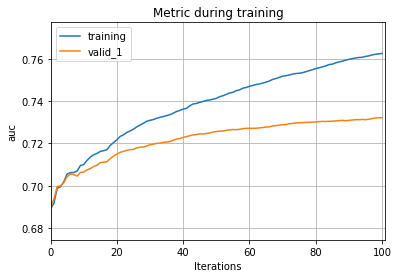

In [48]:
lgb.plot_metric(model, metric='auc')

In [49]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [50]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

DepTime              11
Origin                5
days_since_ny         3
minute                3
minute_cos            2
days_since_ny_cos     2
UniqueCarrier         1
month                 0
DayofMonth            0
DayOfWeek             0
Dest                  0
Distance              0
hour                  0
d_month               0
d_week                0
after_midnight        0
secs_since_ny         0
minute_sin            0
hour_sin              0
hour_cos              0
d_week_sin            0
d_week_cos            0
d_month_sin           0
d_month_cos           0
month_sin             0
month_cos             0
days_since_ny_sin     0
Month                 0
dtype: int32

# Validate

In [51]:
def get_proba(X, model):
    return special.expit(model.predict(X))

In [52]:
tr_proba = get_proba(X_tr, model)

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


In [53]:
roc_auc_score(y_tr, tr_proba)

0.6892009541125987

In [54]:
roc_auc_score(y_train, get_proba(X_train, model))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


0.6892809675160841

In [55]:
roc_auc_score(y_test, get_proba(X_test, model))

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


0.6821596551737003

# Commit

## Refit on full dataset

In [56]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [57]:
enc.fit(X[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [58]:
X = preproc(X)

In [59]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [60]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          sample_weight=sample_weights(y_tr),
          eval_sample_weight=[sample_weights(y_tr), sample_weights(y_es)],
          init_score=fl.init_score(y_tr),
          eval_init_score=[fl.init_score(y_tr),
                           fl.init_score(y_es)],
          early_stopping_rounds=100,
          verbose=50)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightG

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	training's auc: 0.740218	training's binary_logloss: 16.9179	valid_1's auc: 0.72338	valid_1's binary_logloss: 16.9207
[100]	training's auc: 0.75894	training's binary_logloss: 16.9189	valid_1's auc: 0.734029	valid_1's binary_logloss: 16.9225
Early stopping, best iteration is:
[1]	training's auc: 0.694214	training's binary_logloss: 16.8277	valid_1's auc: 0.687387	valid_1's binary_logloss: 16.8293
CPU times: user 14.7 s, sys: 542 ms, total: 15.3 s
Wall time: 4.49 s


LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               learning_rate=0.02238858415024258, max_depth=10,
               min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               objective=<bound method FocalLoss.lgb_obj of <__main__.FocalLoss object at 0x7ff98de140d0>>,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

## Prepare test

In [61]:
test = preproc(test)

In [62]:
test['dep_delayed_15min'] = get_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'),
                                      model)

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:925: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  warnings.warn("Cannot compute class probabilities or labels "


In [63]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.73029